## Training Xception Model on FLAME Dataset

Transfer Learning is used in this work for model traning and fine-tunning.

### Steps shown below :

![caption](files/model_fc.jpg)


### 1 Load the libraries

In [29]:
import numpy as np
import datetime
import cv2 
import os

#importing tensorflow and keras for modelling
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Activation,Conv2D,Dense,MaxPool2D,Dropout,Flatten,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import Xception
from tensorflow.keras.regularizers import l2
from keras.models import model_from_json
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,accuracy_score,classification_report
from sklearn import metrics
# libraries for plotting graphs
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from IPython.display import Image, display

import seaborn as sns

2. we define the paths of images and initialization of some parameters like image size and batch

In [6]:
#Directory path for images
Base_directory = '/kaggle/input/flame-dataset-fire-classification'
test_path = 'Test/Test'
Training_path = 'Training/Training'

#input image shape
input_shape = (254,254,3)

#batch size for the CNN
batch = 16

labels = ['Fire','No_Fire']

#defining the full path for the files
Full_Training_path = '{0}/{1}'.format(Base_directory,Training_path)
Full_Test_path = '{0}/{1}'.format(Base_directory,test_path)

### 3. Data Analysis

Displaying few sample images from each class


 FIRE


<Figure size 432x288 with 0 Axes>

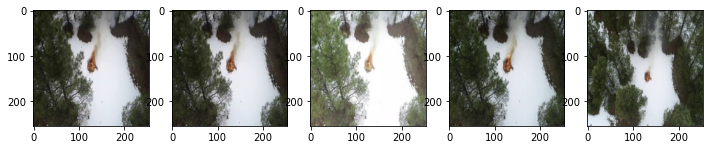

There are  25018  images in  Fire class

 NO_FIRE


<Figure size 432x288 with 0 Axes>

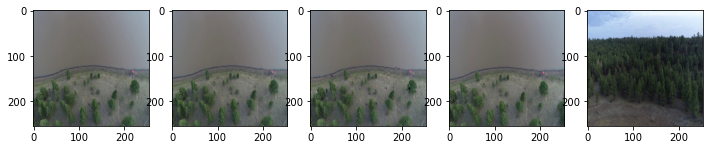

There are  14357  images in  No_Fire class


In [14]:
num = []
for label in labels:
    path = '{0}/{1}/'.format(Full_Training_path,label)
    folder_data = os.listdir(path)
    k = 0
    fig = figure()
    f,ax = plt.subplots(1,5,figsize=(12, 6))
    print('\n', label.upper())
    for image_path in folder_data:
        if k < 5:           
            image = imread(path+image_path)           
            ax[k].imshow(image)                        
        k = k+1
    num.append(k)
    plt.show()
    print('There are ', k,' images in ', label, 'class')

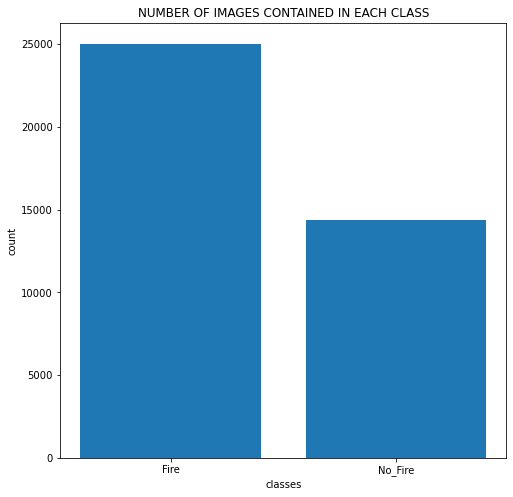

In [15]:
plt.figure(figsize = (8,8))
plt.bar(labels, num)
plt.title('NUMBER OF IMAGES CONTAINED IN EACH CLASS')
plt.xlabel('classes')
plt.ylabel('count')
plt.show()

#### Image Augmentation is an important step. We pass the image to ImageDataGenerator.

In [7]:
#loading the train images to imagegenerator. We keep 20% of the data for validation
train_images = ImageDataGenerator(rotation_range=45,   #To rotate the image by max 45 degree
                                 horizontal_flip=True, # Flip horizontally
                                 vertical_flip=True,   # flip vertically                                  
                                 rescale=1.0/255,      # re-scale the RGB values between 0-1
                                 zoom_range=0.4,       # Zoom by factor 0.4
                                 shear_range=0.2,      # shear by factor 0.2
                                 fill_mode='nearest',  #fill the pixel by nearest value
                                 validation_split=0.2) # split the training set for validation - 20%

train_generator = train_images.flow_from_directory(Full_Training_path, 
                                               target_size=(254,254), #Set tge target image size 
                                               color_mode='rgb',      # generate color images
                                               class_mode='binary',   # target classes - 2 
                                               batch_size=batch,      # batch size set to 16
                                               #shuffle=True,
                                               subset='training')

validation_generator = train_images.flow_from_directory(Full_Training_path, 
                                                    target_size=(254,254),
                                                    color_mode='rgb',
                                                    class_mode='binary',
                                                    batch_size=batch,
                                                    #shuffle=True,
                                                    subset='validation')

test_images = ImageDataGenerator(rescale=1.0/255)  # re-scale the RGB values between 0-1 

test_generator = test_images.flow_from_directory(Full_Test_path, 
                                                target_size=(254,254), 
                                                color_mode='rgb', 
                                                class_mode='binary',
                                                shuffle=False,
                                                batch_size=batch)

Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [11]:
# defining input tensor for the model
img_input = Input(shape=input_shape)

# load the pre-trainined Xception Model
model = Xception(
    include_top=False,     # We will not include the top FC layers
    weights="imagenet",
    input_tensor=img_input,  # Input Tensor
    input_shape=input_shape, # Image size
    pooling='avg')           # pooling method is avg

In [12]:
# Fine Tuning of the Model 

last_layer = model.output  # Load the model Output 
x = Flatten(name='flatten')(last_layer) # Flatten the layer
x = Dense(1024, activation='relu', name='fc1')(x)  
out = Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='linear')(x)  ## 2 classes
model = Model(img_input, out)

#we will train last 60 layers of the model and freeze rest
for layer in model.layers[:-60]:
    layer.trainable = False
    

In [10]:
for i,layer in enumerate(model.layers):
    print(i,layer.name,layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d_4 False
13 block2_pool False
14 batch_normalization_4 False
15 add_12 False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_5 False
23 block3_pool False
24 batch_normalization_5 False
25 add_13 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_6 False
33 block4_pool False
34 batch_normalization_6 False
35 add_14 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepco

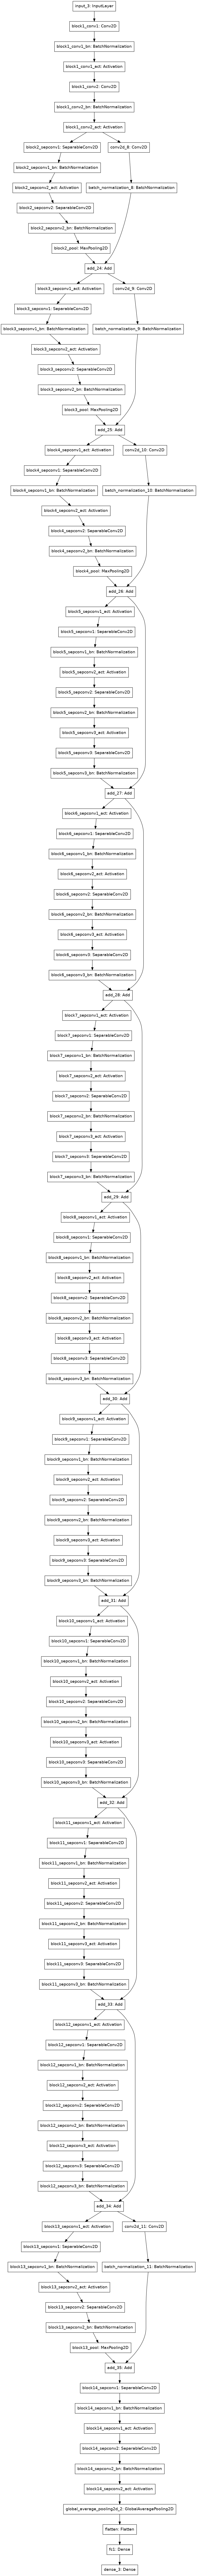

In [13]:
plot_model(model)

In [34]:
# saving the model
model_json = model.to_json()
with open("Xception_saved_model.json", "w") as json_file:
    json_file.write(model_json)

In [14]:
# Defining the callbacks

#custum definined callback for test data evaluation after each epoch
class TestCallback(Callback): # Extend Callback class
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):  # overwrite on_epoch_end function
        testdata = self.test_data
        loss, acc = self.model.evaluate(testdata, verbose=0)  # test set evaluation
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))
        
#defining all call backs 
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1),
    ModelCheckpoint(filepath='Xception_2504_{epoch:02d}_{val_accuracy:.04f}.h5',save_best_only=False),
    TestCallback(test_generator)]       


#compile the model 
model.compile( loss = 'hinge',  #hinge loss
              optimizer='AdaMax', 
              metrics='accuracy')


In [27]:
#train the model
history = model.fit(train_generator,
            epochs=50,                            # 50 epochs 
            validation_data = validation_generator,            
            callbacks=my_callbacks,
            verbose=1    )

Epoch 1/50
1969/1969 [==============================] - 1070s 539ms/step - loss: 0.0052 - accuracy: 0.9978 - val_loss: 0.0895 - val_accuracy: 0.9688

Testing loss: 0.39582520723342896, acc: 0.8444934487342834

Epoch 2/50
1969/1969 [==============================] - 841s 427ms/step - loss: 0.0036 - accuracy: 0.9984 - val_loss: 0.0856 - val_accuracy: 0.9719

Testing loss: 0.40500742197036743, acc: 0.8523848056793213

Epoch 3/50
1969/1969 [==============================] - 839s 426ms/step - loss: 0.0044 - accuracy: 0.9984 - val_loss: 0.0580 - val_accuracy: 0.9827

Testing loss: 0.3520274758338928, acc: 0.8583033680915833

Epoch 4/50
1969/1969 [==============================] - 834s 423ms/step - loss: 0.0049 - accuracy: 0.9978 - val_loss: 0.0647 - val_accuracy: 0.9806

Testing loss: 0.6477533578872681, acc: 0.7786932587623596

Epoch 5/50
1969/1969 [==============================] - 809s 411ms/step - loss: 0.0052 - accuracy: 0.9978 - val_loss: 0.0655 - val_accuracy: 0.9785

Testing loss: 0.

### Evaluation

#### Load the saves model and weights

After training multiple times the best weights were saved 

In [4]:
#load the saved model. have saved the model in json format 
json_file = open('{0}/{1}'.format(Base_directory, 'Xception_saved_model.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()

#define the model
model = model_from_json(loaded_model_json)

#load the weights
model.load_weights('{0}/{1}'.format(Base_directory, 'Xception_saved_weights.h5'))


In [8]:
#Make prediction on test set
y_pred = model.predict(test_generator)

In [11]:
#convert the output to binary form 0 and 1
y_pred = [1 if x>0.5 else 0 for x in y_pred]

#Actaul test class
y_true = test_generator.classes

accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_true, y_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred)
print('F1 score: %f' % f1)

[[4604  533]
 [ 191 3289]]
Accuracy: 0.915980
Precision: 0.860544
Recall: 0.945115
F1 score: 0.900849


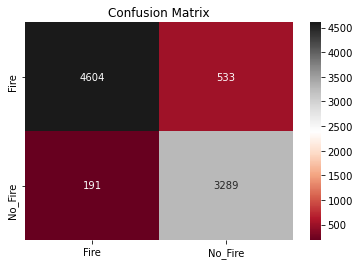

In [30]:
conf_matrix=metrics.confusion_matrix(y_true, y_pred)
ax = sns.heatmap(conf_matrix,annot=True,cmap='RdGy', xticklabels=['Fire', 'No_Fire'], yticklabels=['Fire', 'No_Fire'],fmt='g').set_title('Confusion Matrix')
fig = ax.get_figure()

In [33]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      5137
           1       0.86      0.95      0.90      3480

    accuracy                           0.92      8617
   macro avg       0.91      0.92      0.91      8617
weighted avg       0.92      0.92      0.92      8617

